In [1]:
!pip install deepxde

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.3/165.3 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 12.0 MB/s eta 0:00:00


In [2]:
# Importing required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

# Importing DeepXDE library for solving partial differential equations using deep learning
import deepxde as dde

# Importing Scikit-Optimize library for Bayesian hyperparameter optimization
import skopt
from skopt import gp_minimize
from skopt.plots import plot_convergence, plot_objective
from skopt.space import Real, Categorical, Integer
from skopt.utils import use_named_args

No backend selected.
Finding available backend...


Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.
Instructions for updating:
non-resource variables are not supported in the long term


Found tensorflow.compat.v1
Setting the default backend to "tensorflow.compat.v1". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)


In [3]:
# Checking the backend being used (PyTorch or TensorFlow) for defining sin function accordingly
if dde.backend.backend_name == "pytorch":
    sin = dde.backend.pytorch.sin
else:
    from deepxde.backend import tf

    sin = tf.sin

# Defining the PDE to be solved
def pde(x, y):
    dy_x = dde.grad.jacobian(y, x, i=0, j=0)
    dy_t = dde.grad.jacobian(y, x, i=0, j=1)
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
    dy_xxx = dde.grad.hessian(dy_x, x, i=0, j=0)
    dy_xxxx = dde.grad.hessian(dy_xx, x,i=0, j=0)

    return dy_t + y * dy_x -0.5 * dy_xx

# Defining the geometry and time domain for the problem
geom = dde.geometry.Interval(0, 10)  # Interval geometry from 0 to 10
timedomain = dde.geometry.TimeDomain(0, 1)  # Time domain from 0 to 1
geomtime = dde.geometry.GeometryXTime(geom, timedomain)  # Combining geometry and time domain

# Setting up boundary and initial conditions
bc = dde.DirichletBC(geomtime, lambda x: 0, lambda _, on_boundary: on_boundary)
ic = dde.IC(geomtime, lambda x: np.sin((3.0/5)*np.pi * x[:, 0:1]), lambda _, on_initial: on_initial)

# Generating training and testing data for the PDE solver
data = dde.data.TimePDE(geomtime, pde, [bc, ic], num_domain=500, num_boundary=100, num_initial=100, num_test=1000)



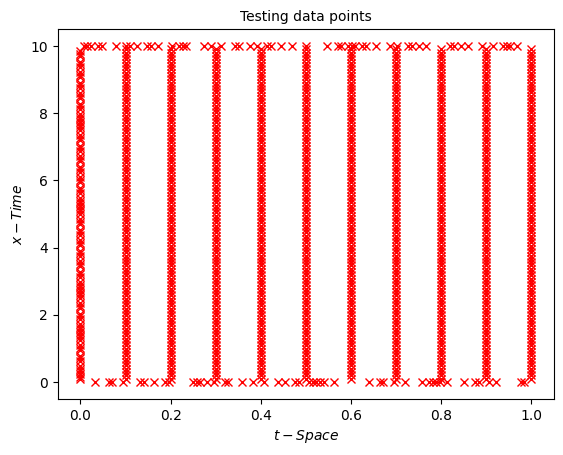

In [4]:
# Extracting the testing data points from the 'data' object
x_test = data.test_points()[:, 1]
t_test = data.test_points()[:, 0]

# Plotting the testing data points using red crosses ('xr')
plt.plot(x_test, t_test, 'xr', clip_on=False)

# Setting the labels and title for the plot
plt.xlabel('$t-Space$')
plt.ylabel('$x-Time$')
plt.title('Testing data points', fontsize=10)

# Saving the plot as 'test_data.eps' with dpi (dots per inch) set to 100
plt.savefig('test_data.eps', dpi=100)


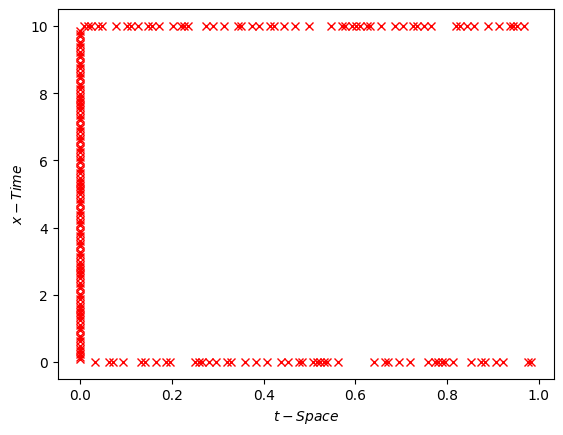

In [5]:
# Extracting the boundary condition (BC) points from the 'data' object
x_bc = data.bc_points()[:, 1]
t_bc = data.bc_points()[:, 0]

# Plotting the boundary condition (BC) points using red crosses ('xr')
plt.plot(x_bc, t_bc, 'xr', clip_on=False)

# Setting the labels for the plot
plt.xlabel('$t-Space$')
plt.ylabel('$x-Time$')

# Display the plot
plt.show()
#plt.autoscale(enable=True, axis='both', tight=True)

In [7]:
# Number of Boundary points
len(data.bc_points())

200

In [6]:
# Find the common elements on Test dataset
common_elements = np.array([x for x in data.train_points() if np.any(np.all(x == data.test_points(), axis=1))])
num_common_elements = common_elements.shape[0]
print("Number of common elements:", num_common_elements)


Number of common elements: 200


Text(0, 0.5, '$x-time$')

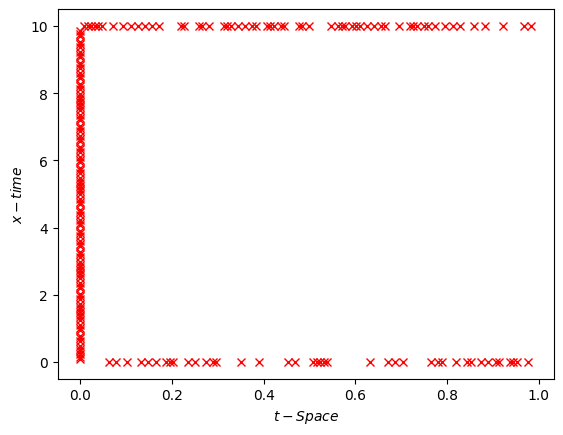

In [ ]:
# Display the common points
plt.plot(common_elements[:,1],common_elements[:,0],'xr',clip_on = False)
plt.xlabel('$t-Space$')
plt.ylabel('$x-time$')

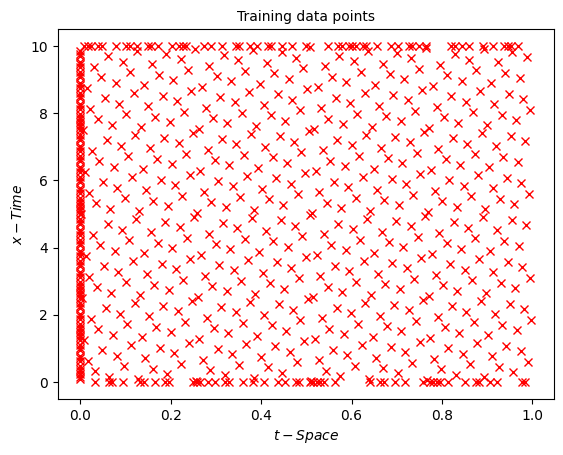

In [8]:


# Extracting the training data points from the 'data' object
x_train = data.train_points()[:, 1]
t_train = data.train_points()[:, 0]

# Plotting the training data points using red crosses ('xr')
plt.plot(x_train, t_train, 'xr', clip_on=False)

# Setting the labels and title for the plot
plt.xlabel('$t-Space$')
plt.ylabel('$x-Time$')
plt.title('Training data points', fontsize=10)

# Saving the plot as 'Training_data.eps' with dpi (dots per inch) set to 100
plt.savefig('Training_data.eps', dpi=100)


Compiling model...
Building feed-forward neural network...
'build' took 0.396306 s

'compile' took 4.926310 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [1.24e-02, 7.48e-02, 5.56e-01]    [4.92e-03, 7.48e-02, 5.56e-01]    []  
500       [7.65e-03, 7.58e-03, 4.00e-01]    [6.44e-03, 7.58e-03, 4.00e-01]    []  
1000      [4.73e-02, 7.43e-03, 1.02e-01]    [2.52e-02, 7.43e-03, 1.02e-01]    []  
1500      [2.20e-02, 1.13e-03, 1.78e-02]    [1.01e-02, 1.13e-03, 1.78e-02]    []  
2000      [1.15e-02, 7.81e-04, 8.39e-03]    [5.46e-03, 7.81e-04, 8.39e-03]    []  
2500      [7.86e-03, 4.32e-04, 6.64e-03]    [3.68e-03, 4.32e-04, 6.64e-03]    []  
3000      [5.68e-03, 2.65e-04, 6.00e-03]    [2.66e-03, 2.65e-04, 6.00e-03]    []  
3500      [3.91e-03, 2.25e-04, 5.49e-03]    [2.00e-03, 2.25e-04, 5.49e-03]    []  
4000      [2.95e-03, 2.18e-04, 4.85e-03]    [1.72e-03, 2.18e-04, 4.85e-03]    []  
4500      [2.41e-03, 2.05e-04, 4.

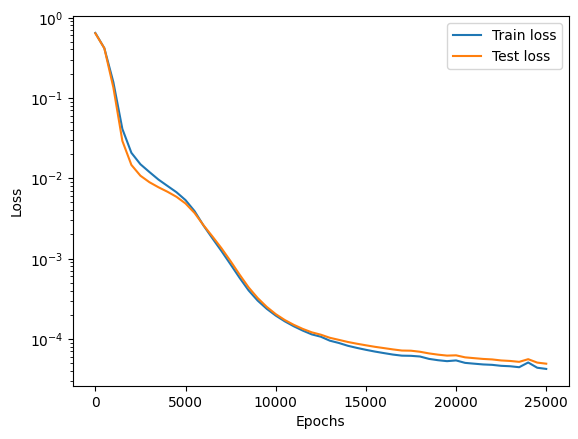

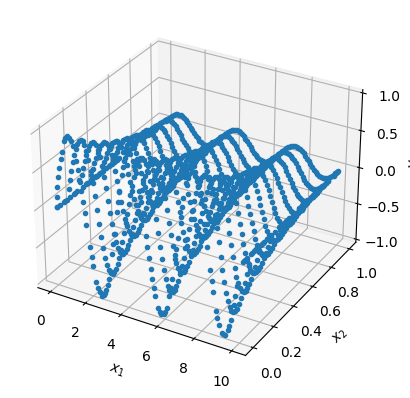

In [ ]:
# Bayesian optimal parameters for PINN used here for final model development
# Setting a specific random seed for reproducibility
dde.config.set_random_seed(27)
lamda=0.0311

# Defining the neural network architecture with 4 hidden layers, each having 16 units and using 'sin' activation function
net = dde.nn.FNN([2] + [16] * 4 + [1], "sin", "Glorot normal")

# Creating the PINN model with the specified data and neural network
model = dde.Model(data, net)

# Compiling the model with the 'adam' optimizer and a specific learning rate
model.compile("adam", lr=0.0001416)

# Training the model for 25000 iterations and displaying the training progress every 500 iterations
losshistory, train_state = model.train(iterations=25000, display_every=500)

# Saving the plot of the loss history and the state of the training process (optional)
dde.saveplot(losshistory, train_state, issave=True, isplot=True)


In [49]:
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.use('pgf')
import tensorflow as tf
import numpy as np
import scipy.io
from scipy.interpolate import griddata
import time
from itertools import product, combinations
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
#from plotting import newfig, savefig
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspe

In [74]:
# Generating time (t) and space (x) grids
t=np.linspace(0,1,101).reshape(-1,1) # 101 evenly spaced points between 0 and 1, reshaped to a column vector
x=np.linspace(0,10,101).reshape(-1,1)# 101 evenly spaced points between 0 and 10, reshaped to a column vector
# Creating 2D grids (xx and tt) from 1D x and t arrays
xx, tt = np.meshgrid(x, t)
# Stacking the xx and tt grids to form the input data matrix X
X = np.vstack((np.ravel(xx), np.ravel(tt))).T

# Predicting the solution using the trained model
y_pred = model.predict(X)
# Predicting the residual using the trained model
f = model.predict(X, operator=pde)
print("Mean residual:", np.mean(np.absolute(f)))
U_pred =y_pred.flatten().reshape(101,101) # Predicted solution Over the 2D domain

Mean residual: 0.0044683046


In [20]:
def figsize(scale, nplots = 1):
    fig_width_pt = 590.0                          # Get this from LaTeX using \the\textwidth
    inches_per_pt = 1.0/72.27                       # Convert pt to inch
    golden_mean = (np.sqrt(5.0)-1.0)/2.0            # Aesthetic ratio (you could change this)
    fig_width = fig_width_pt*inches_per_pt*scale    # width in inches
    fig_height = nplots*fig_width*golden_mean              # height in inches
    fig_size = [fig_width,fig_height]
    return fig_size
# I make my own newfig and savefig functions
def newfig(width, nplots = 1):
    fig = plt.figure(figsize=figsize(width, nplots))
    ax = fig.add_subplot(111)
    return fig, ax

def savefig(filename, crop = True):
    if crop == True:
#        plt.savefig('{}.pgf'.format(filename), bbox_inches='tight', pad_inches=0)
        plt.savefig('{}.pdf'.format(filename), bbox_inches='tight', pad_inches=0)
        plt.savefig('{}.eps'.format(filename), bbox_inches='tight', pad_inches=0)
    else:
#        plt.savefig('{}.pgf'.format(filename))
        plt.savefig('{}.pdf'.format(filename))
        plt.savefig('{}.eps'.format(filename))
############################## Helper Functions ###############################

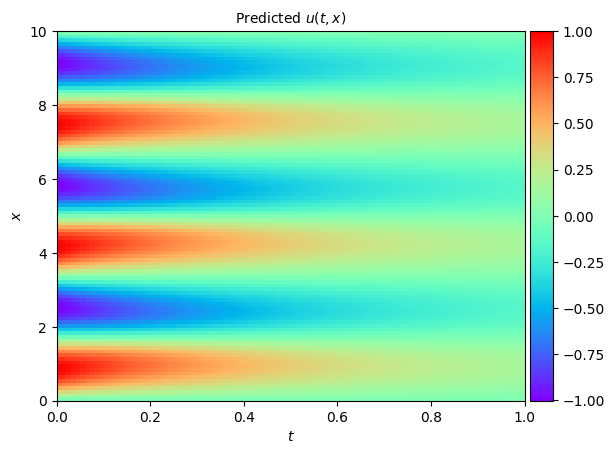

In [75]:
# Importing the required libraries
import matplotlib.gridspec as gridspec
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

# Create a figure and a set of subplots
fig, ax = plt.subplots()

# Plot the 2D image of the predicted solution using imshow
h = ax.imshow(U_pred.T, interpolation='nearest', cmap='rainbow',
              extent=[t.min(), t.max(), x.min(), x.max()],
              origin='lower', aspect='auto')

# Add a colorbar for the image
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)

# Set the labels, title
ax.set_xlabel('$t$')
ax.set_ylabel('$x$')

ax.set_title('Predicted $u(t,x)$', fontsize=10)

# Save the plot as 'u_pred1.eps' with dpi (dots per inch) set to 100
plt.savefig('u_pred1.eps', dpi=100)



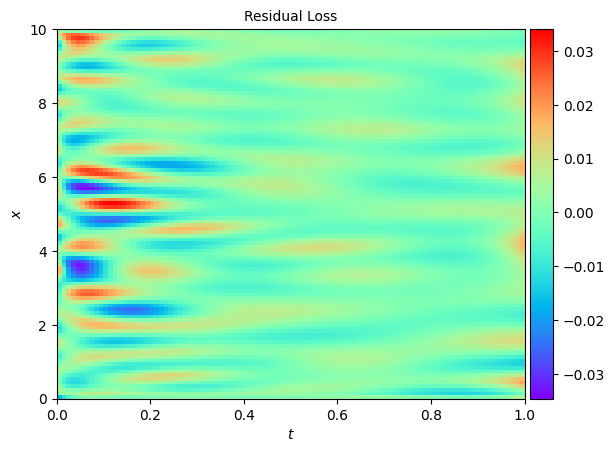

In [76]:
# Pde Residual loss
# Create a figure and a set of subplots
fig, ax = plt.subplots()

# Plot the 2D image of the residual using imshow
h = ax.imshow(f.reshape(101, 101).T, interpolation='nearest', cmap='rainbow',
              extent=[t.min(), t.max(), x.min(), x.max()],
              origin='lower', aspect='auto')

# Add a colorbar for the image
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)

# Set the labels, title, and legend for the plot
ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
ax.set_title('Residual Loss', fontsize=10)

# Save the plot as 'u_residual.eps' with dpi (dots per inch) set to 100
plt.savefig('u_residual.eps', dpi=100)


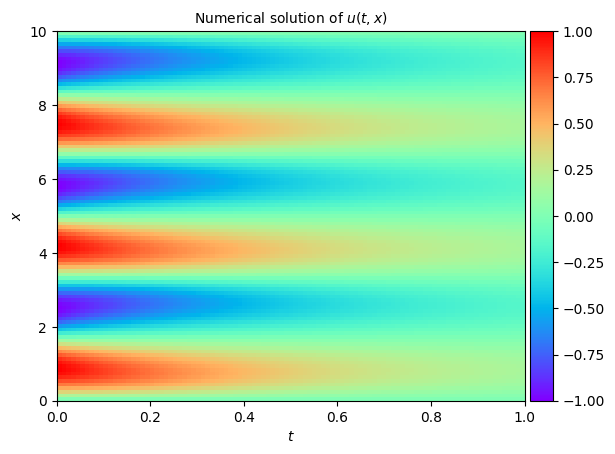

In [80]:
# Numirical validation using finite
fig, ax = plt.subplots()

# Parameters
Nx = 100  # N0umber of grid points in x
Nt = 100  # Number of grid points in t
T = 1.0   # Total time

# Discretization steps
dx = 10.0 / Nx
dt = T / Nt

# Create grid
x = np.linspace(0, 10, Nx+1)
t = np.linspace(0, T, Nt+1)

u = np.zeros((Nt+1, Nx+1))
# Set the boundary condition
u[:,0]=0
u[:,Nx]=0

####Set the initial condition

u[0, :] = np.sin(3*np.pi*x/5)

#u[0, :] = np.cos(4*np.pi*x/5)

# Solve the PDE using finite differences
for n in range(Nt):
    for i in range(1, Nx):
        u_x = (u[n, i+1] - u[n, i-1]) / (2 * dx)  # Centered difference for u_x
        u_xx = (u[n, i+1] - 2*u[n, i] + u[n, i-1]) / dx**2  # Centered difference for u_xx
        u_t = -u[n, i] * u_x  # Given equation u_t + u * u_x = 0.5 * u_xx

        u[n+1, i] = u[n, i] + dt * (0.5 * u_xx - u_t)

h = ax.imshow(u.T, interpolation='nearest', cmap='rainbow',
                  extent=[t.min(), t.max(), x.min(), x.max()],
                  origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)
line = np.linspace(x.min(), x.max(), 2)[:,None]
ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
ax.set_title('Numerical solution of $u(t,x)$', fontsize = 10)
plt.savefig('u_pred_numerical.eps',dpi=100)

In [69]:
u.T.shape

(101, 101)